# HomeMatch Application: A Personalized Real Estate Agent

code by: @amirhnazerii


In [20]:
# Mount Google Drive to access files stored in the Drive
from google.colab import drive
drive.mount('/content/drive')

# Add custom path to the system path to access specific project files
import sys
custom_path = "/content/drive/.../"
sys.path.append(custom_path)

# Install necessary libraries (uncomment to install)
# !pip install flask flask-ngrok langchain openai chromadb pydantic requests pillow
# !pip install -U langchain-community
# !pip install gradio
# !pip install chromadb
# !pip install tiktoken

# Import necessary libraries for building the system
import gradio as gr
from PIL import Image
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
import requests
import io
import os
import json

# Set OpenAI API Key to use OpenAI's GPT models
os.environ['OPENAI_API_KEY'] = 'YOUR_API_KEY'

# Load and parse the real estate listings dataset (CSV and JSON formats)
loader = CSVLoader(file_path= custom_path + 'RealEstateListingsDatasetv2.csv')
docs = loader.load()  # Load documents from the CSV file

# Load JSON-based listings data that include "image urls"
with open(custom_path+'RealEstateListingsDatasetv3.json', 'r') as f:
    listings = json.load(f)  # Load listings from a JSON file

# Split loaded documents into smaller chunks for better processing
splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=0)
split_docs = splitter.split_documents(docs)  # Split documents into chunks

# Create embeddings for the documents using OpenAI's embeddings model
embeddings = OpenAIEmbeddings()

# Store the documents and their embeddings in a vector database (Chroma)
db = Chroma.from_documents(split_docs, embeddings)

# Load the language model (GPT-3.5-turbo)
llm = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0, max_tokens=2000)

# Define the output format using Pydantic model for structured data
class ChainOutput(BaseModel):
    # Response with the description of the listing
    response: str = Field(..., description="A professional, customer-facing marketing in-detailed description about the matched listing")
    # The most similar listing based on the query
    most_similar_listing: dict = Field(..., description="The most relevant listing with all keys")

# Set up a parser that uses the Pydantic model to parse the output
parser = PydanticOutputParser(pydantic_object=ChainOutput)

# Define the context for the real estate assistant (AI will act as a licensed realtor)
context = """You are a professional licensed real estate realtor.
Based on the retrieved information, professionally market the matched listing to the customer in about 70 words. \n
Avoid making up inaccurate content."""

# Define a prompt template for asking the assistant questions
prompt = PromptTemplate(
    template="{context}\n\nformat_instructions: {format_instructions}\nuser: {question}",
    input_variables=["question", "context"],
    partial_variables={"format_instructions": parser.get_format_instructions},
)

# Function to fetch and display an image from a URL
def fetch_image(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)

    # Check if the response contains a valid image
    if response.status_code != 200 or not response.headers.get('Content-Type', '').startswith('image/'):
        raise ValueError("Image not accessible")
    return Image.open(io.BytesIO(response.content))

# Gradio function to handle real estate assistant queries
def real_estate_assistant(question):
    try:
        # Format the query using the prompt template
        query = prompt.format(context=context, question=question)

        # Use RetrievalQA to find relevant documents for the question
        rag = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=db.as_retriever())
        similar_docs = db.similarity_search(question, k=1)  # Get the top 1 most relevant document
        output = rag.run(query + " ".join([doc.page_content for doc in similar_docs]))  # Generate a response

        # Parse the output using the Pydantic model
        result = parser.parse(output)
        result_dict = result.dict()  # Convert parsed result to dictionary
        print(result_dict["most_similar_listing"])  # Print the most similar listing
        listing_id = result_dict["most_similar_listing"].get("id")
        print(listing_id)  # Print listing ID
        image_url = listings[listing_id].get("url")  # Get the image URL from the listing data

        # Fetch and display the listing image if available
        if image_url:
            img = fetch_image(image_url)
            return result_dict["response"], img  # Return the description and image
        else:
            return result_dict["response"], None  # Return only description if no image is available
    except Exception as e:
        return str(e), None  # Handle errors gracefully

# Create the Gradio interface to interact with the real estate assistant
interface = gr.Interface(
    fn=real_estate_assistant,
    inputs=gr.Textbox(lines=2, placeholder="Ask a question about real estate listings..."),  # Text input for the user
    outputs=[
        gr.Textbox(label="Listing Description"),  # Output for the listing description
        gr.Image(label="Listing Image"),  # Output for the listing image
    ],
    title="AI Real Estate Assistant",  # Title for the interface
    description="""Hi Dear! \\
     I am your professional real-estate agent. :) \\
     Describe your dream house and I will find you the best match from our listings!"""  # Description for the interface
)

# Launch the Gradio interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://31b9de8f2826198f89.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


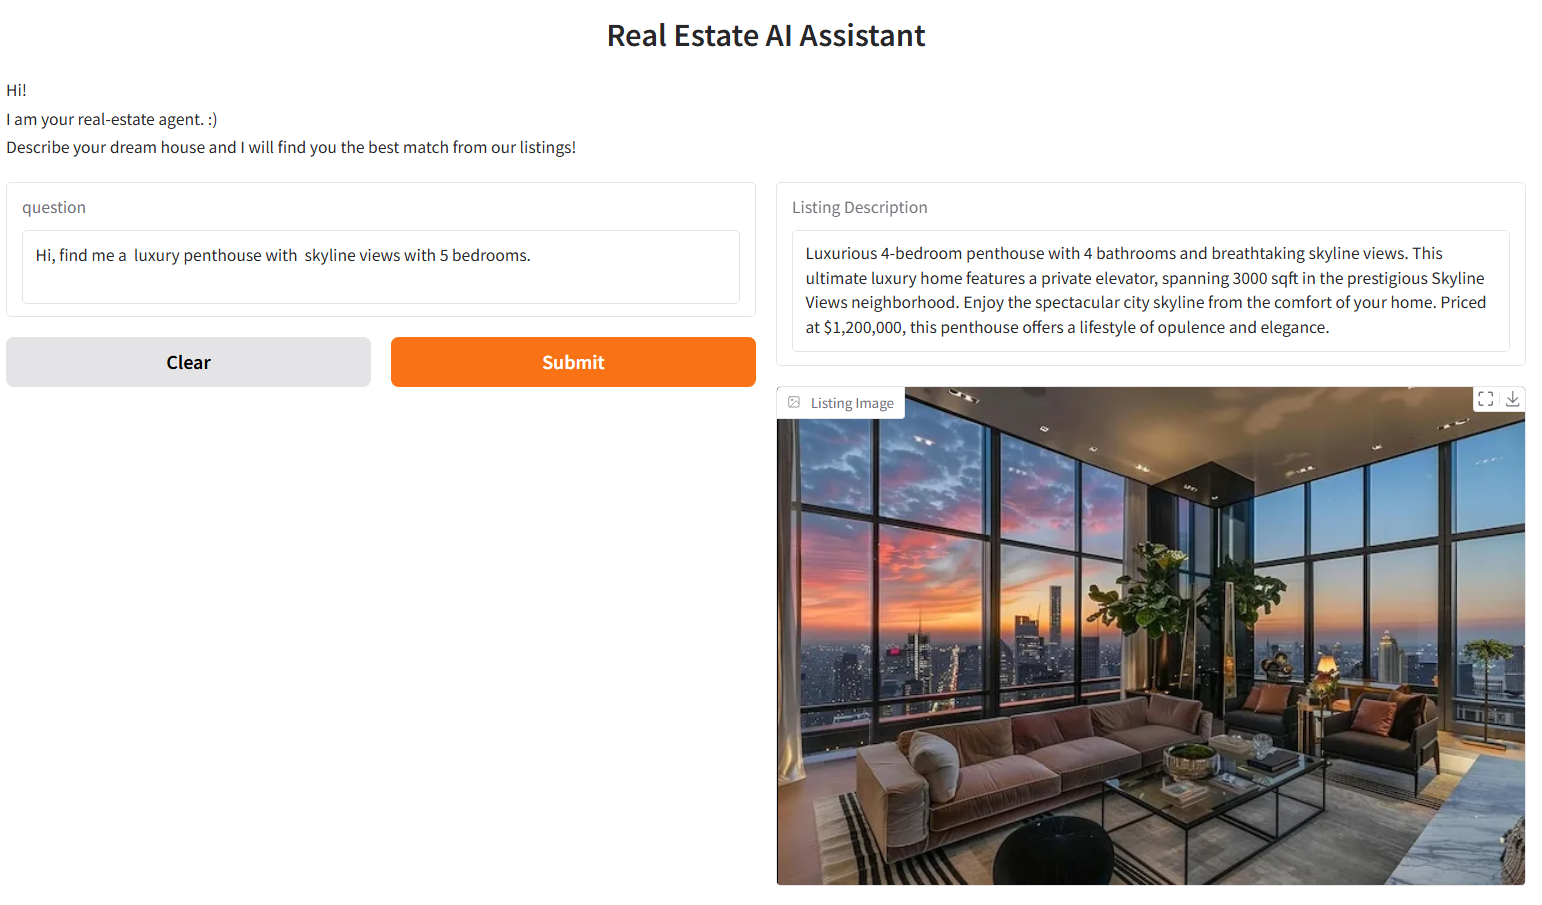

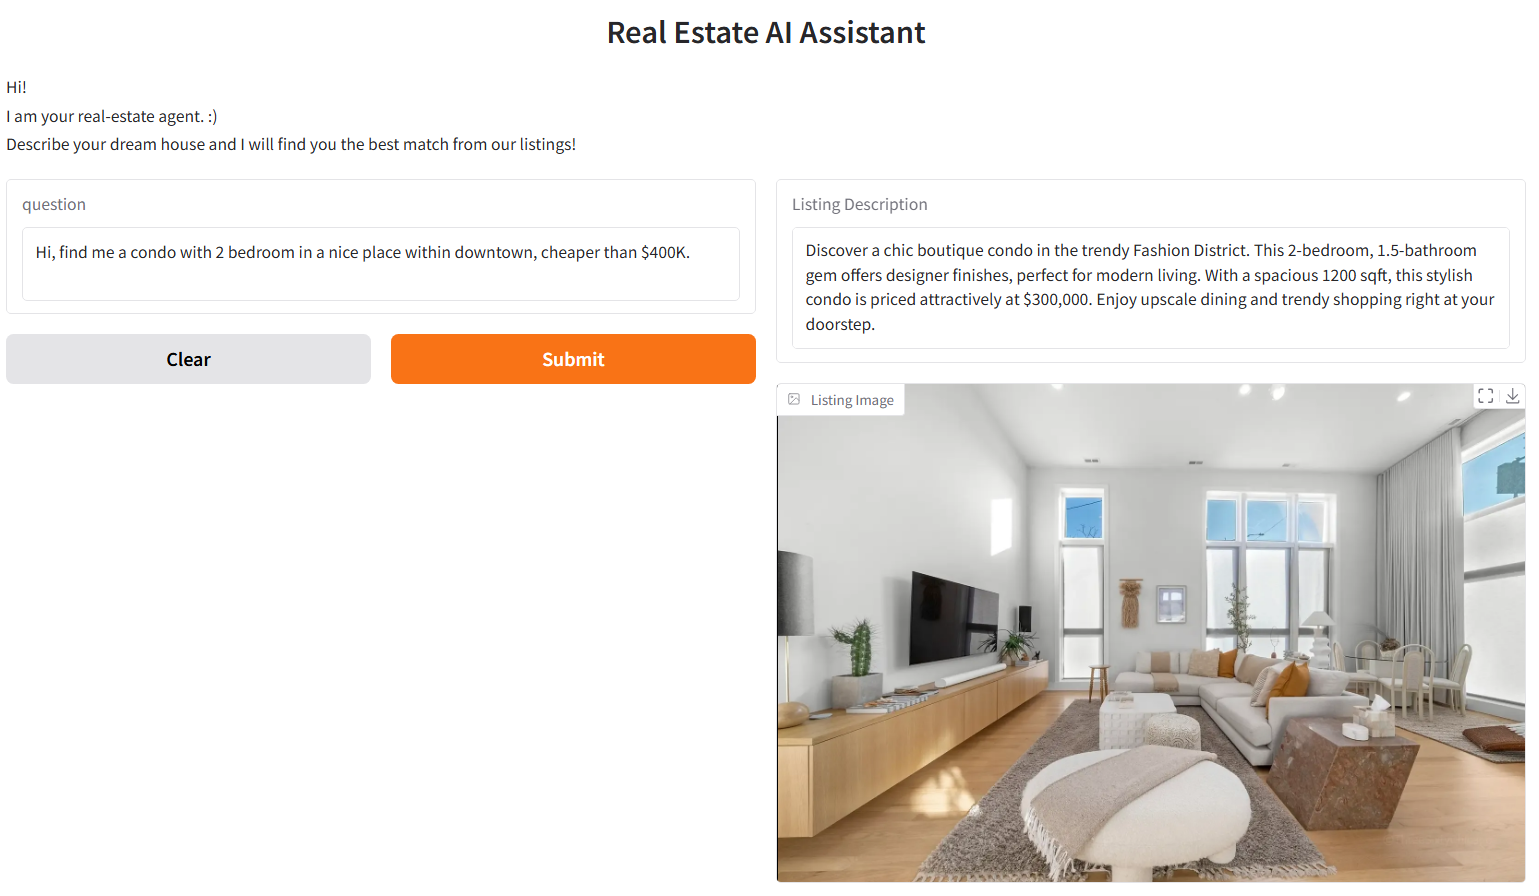